In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mceq_config as config
from MCEq.core import MCEqRun
import crflux.models as pm
import scienceplots
import scipy.optimize as opt
from utils.helpers import *

In [13]:
class SensitivityAnalyzer:
    def __init__(self, ptype, scale_factor_p, scale_factor_k, doys, threshold, increase):
        """
        Initialize the SensitivityAnalyzer with the parameters.

        Parameters: - change description later
        - ptype (str): Target particle: mu or numu. (total flux)
        - cs_p (float): Pion-air cs factor (increase or decrease)
        - cs_k (float): Kaon-air cs factor (increase or decrease)
        - doys (list): List of days of the year for analysis.
        - const (string): threshold above whic cross section is changed.
        """
        self.ptype = ptype
        self.scale_factor_p = scale_factor_p
        self.scale_factor_k = scale_factor_k
        self.threshold = threshold
        self.increase = increase
       
        self.doys = doys
        self.cs_mod =  self.ptype + '_' + str(self.scale_factor_p) + 'pion_' + str(self.scale_factor_k) + 'kaon_' +  str(self.threshold) + '_' + self.increase
               
    def ebins_analysis(self):
        step = 0.3
        ebins = np.logspace(2.1, 6, num=int((6 - 2.1) / step) + 1)
        return ebins

    def energybins_mceq(self):
        mceq = MCEqRun(
            interaction_model="SIBYLL2.3c",
            theta_deg=0.0,
            primary_model=(pm.HillasGaisser2012, "H3a"),
        )

        energy = mceq.e_grid
        return energy

    def load_data(self): # change

        self.flux_tuned = np.load(f'/data/user/khymon/cs-analysis/{self.ptype}_{self.scale_factor_p}pion_{self.scale_factor_k}kaon_{self.threshold}_{self.increase}_mceqflux.npy')
        if self.increase == 'const':
            self.flux_untuned = np.load(f'/data/user/khymon/cs-analysis/{self.ptype}_1.0pion_1.0kaon_{self.threshold}_{self.increase}_mceqflux.npy')
        elif self.increase == 'exp':
            self.flux_untuned = np.load(f'/data/user/khymon/cs-analysis/{self.ptype}_0.0pion_0.0kaon_{self.threshold}_{self.increase}git_mceqflux.npy')
         

    def get_sv_amplitude(self, flux, energy, ebins, angles_edges, doys):
        masks = []
        flux_year = np.mean(flux, axis=1)

        sv_amplitude = np.ndarray(shape=(len(angles_edges) - 1, len(ebins), len(doys)), dtype=float)

        for i in range(len(ebins) - 1):
            mask = (energy >= ebins[i]) & (energy < ebins[i + 1])
            masks.append(mask)
            for j in range(len(angles_edges) - 1):
                sv_amplitude[j][i] = np.sum(flux[j, :, mask], axis=0) / np.sum(flux_year[j, mask])

        print(sv_amplitude)

        return sv_amplitude

    def get_amplitudes(self):
        angles_edges = angular_bins(self.ptype, 2)
        energy = self.energybins_mceq()
        ebins = self.ebins_analysis()

        self.sv_amplitude_tuned = self.get_sv_amplitude(self.flux_tuned, energy, ebins, angles_edges, self.doys)
        self.sv_amplitude_untuned = self.get_sv_amplitude(self.flux_untuned, energy, ebins, angles_edges, self.doys)

    def deviation_sv_amplitude_plot(self):
        angles_edges =  angular_bins(self.ptype, 2)
        ebins = self.ebins_analysis()

        overall_deviation = np.ndarray(shape=(len(angles_edges) - 1, len(ebins)), dtype=float)
        sensitivity = self.sv_amplitude_tuned / self.sv_amplitude_untuned

        for j in range(len(angles_edges) - 1):
            for i in range(len(ebins) - 1):
                overall_deviation[j][i] = np.sum(np.abs(sensitivity[j][i] - 1))

        plt.figure(figsize=(12, 6))
        for i in range(len(ebins) - 4):
            plt.plot(self.doys, sensitivity[j][i], marker='.', linestyle='-', label=f"{np.round(np.log10(ebins[i]), decimals=1)} $\leq$ log(E/GeV) $\leq$ {np.round(np.log10(ebins[i + 1]), decimals=1)}")
        plt.axhline(y=1, color='black', linestyle='--', label='Original Value')
        plt.title('Daily Sensitivity Across the Year')
        plt.ylabel('Daily deviation from seasonal variation amplitude')
        if self.ptype == 'numu':
            plt.ylim(0.99,1.01)
        elif self.ptype == 'mu':
            plt.ylim(0.99,1.01)
        else:
            print('particle type is not defined.')
            exit()
        plt.xlabel('Day of Year')
        plt.xlim()
        plt.legend(ncol=2)
        plt.grid(True)
        plt.savefig(f'/home/khymon/Plots/cs-analysis/sv_amplitude_mcs_allbins_dailysensitivity{self.cs_mod}_zenith{np.round(angles_edges[0], decimals=0)}-{np.round(angles_edges[1], decimals=0)}.png', bbox_inches='tight')

    def sv_amplitude_plot(self):
        angles_edges  = angular_bins(self.ptype, 2)
        ebins = self.ebins_analysis()

        A4_width_inches = 8.27 * 0.5
        A4_height_inches = A4_width_inches * 0.75 * 2
        figsize = (A4_width_inches, A4_height_inches)

        for j in range(len(angles_edges) - 1):
            fig = plt.figure(figsize=figsize, dpi=500)
            fig.tight_layout()

            plt.rcParams.update({'font.size': 10})
            plt.style.use('science')
            plt.style.use('tableau-colorblind10')
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

            gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[1, 0])
            #ax1.text(100,1.1,str(np.round(angles_edges[j],decimals=1)) + '$^{\circ} \leq \Theta \leq $ ' + str(np.round(angles_edges[j+1])) + '$^{\circ}$')
            

            for i in range(len(ebins) - 1):
                if i < 7:
                    ax1.plot(self.doys, self.sv_amplitude_untuned[j][i], color=colors[i],
                            label=str(np.round(np.log10(ebins[i]),decimals=1)) + r'$\leq \log(E/\text{GeV})\leq$'+ str(np.round(np.log10(ebins[i+1]),decimals=1)))
                    ax1.plot(self.doys, self.sv_amplitude_tuned[j][i], ls='--', color=colors[i])
                else:
                    ax2.plot(self.doys, self.sv_amplitude_untuned[j][i], color=colors[i - 7],
                            label=str(np.round(np.log10(ebins[i]),decimals=1)) + r'$\leq \log(E/\text{GeV})\leq$'+ str(np.round(np.log10(ebins[i+1]),decimals=1)))
                    ax2.plot(self.doys, self.sv_amplitude_tuned[j][i], ls='--', color=colors[i - 7])

            ax1.set_ylim(0.88, 1.11)
            ax1.minorticks_on()
            ax1.set_ylabel('Ratio daily flux to annual average')
            ax1.set_xlabel('Day of Year')
            ax1.legend(fontsize = 'small',ncol=2)
            ax2.set_ylim(0.88, 1.11)
            ax2.minorticks_on()
            ax2.set_ylabel('Ratio daily flux to annual average')
            ax2.set_xlabel('Day of Year')
            ax2.legend(fontsize = 'small',ncol=2)
            plt.grid(True)
            plt.savefig(f'/home/khymon/Plots/cs-analysis/sv_amplitude_mcs_allbins_{self.cs_mod}_zenith{np.round(angles_edges[j], decimals=0)}-{np.round(angles_edges[j + 1], decimals=0)}.png', bbox_inches='tight')


In [14]:
doy = doys(5)

In [15]:
analyzer = SensitivityAnalyzer(ptype='numu', scale_factor_p=1., scale_factor_k=1.2, doys=doy, threshold=1.e4, increase='const')

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
[[[1.03052467e+000 1.03041240e+000 1.03009457e+000 ... 1.02968669e+000
   1.03015265e+000 1.03043828e+000]
  [1.03687775e+000 1.03664957e+000 1.03616887e+000 ... 1.03616219e+000
   1.03661932e+000 1.03686568e+000]
  [1.04162898e+000 1.04129306e+000 1.04066217e+000 ... 1.04103194e+000
   1.04147884e+000 1.04168648e+000]
  ...
  [1.07883510e+000 1.07774183e+000 1.07596132e+000 ... 1.07849247e+000
   1.07915047e+000 1.07928602e+000]
  [1.07286455e+000 1.07181351e+000 1.07011849e+000 ... 1.07262063e+000
   1.07321177e+000 1.07331320e+000]
  [6.91453852e-310 6.91453852e-310 6.91453852e-310 ... 6.91453852e-310
   6.91453852e-310 6.91453852e-310]]

 [[1.03596947e+000 1.03596840e+000 1.03569936e+000 ... 1.03443653e+000
   

/home/khymon/software/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in true_divide


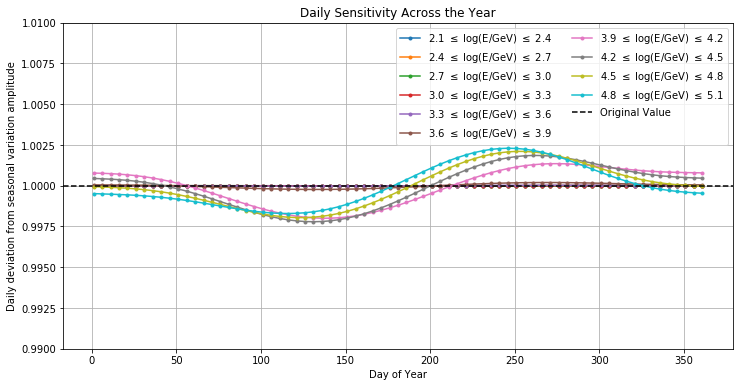

In [16]:
# Load data
analyzer.load_data()

# Calculate amplitudes
analyzer.get_amplitudes()

# Plot deviations
analyzer.deviation_sv_amplitude_plot()